In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

import time

from adversarial_ml import adversarial_attacks as attacks
from adversarial_ml import custom_model as models

# Load MNIST Dataset

In [2]:
(x_train,y_train), (x_test,y_test) = tf.keras.datasets.mnist.load_data()

# Preprocess
x_train = tf.constant(x_train.reshape(60000,28, 28,1).astype("float32") / 255)
x_test = tf.constant(x_test.reshape(10000, 28, 28, 1).astype("float32") / 255)

y_train = tf.constant(y_train.astype("float32"))
y_test = tf.constant(y_test.astype("float32"))

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (60000, 28, 28, 1)
y_train shape: (60000,)
x_test shape: (10000, 28, 28, 1)
y_test shape: (10000,)


# Build Models

In [3]:
class Hparams(object):
    def __init__(self):
        # Model hyperparameters
        self.input_shape = [28, 28, 1]
        self.num_classes = 10
        self.num_conv_filters = [32, 64, 64]
        self.kernel_size = (3, 3)
        self.pool_size = (2, 2)
        self.num_fc_units = [64]
        self.total_batch_size = 32
        self.adv_batch_size = 16
        

hparams = Hparams()

In [4]:
def get_cnn_model(adv_training_with=None, gaussian_noise=0.2):
    # Define Model layers
    inputs = tf.keras.Input(
        shape=[28,28,1], dtype=tf.float32, name="image")

    x = inputs
    x = tf.keras.layers.GaussianNoise(stddev=gaussian_noise)(x)
    # Convolutional layer followed by 
    for i, num_filters in enumerate(hparams.num_conv_filters):
        x = tf.keras.layers.Conv2D(
            num_filters, hparams.kernel_size, activation='relu')(x)
        if i < len(hparams.num_conv_filters) - 1:
            # max pooling between convolutional layers
            x = tf.keras.layers.MaxPooling2D(hparams.pool_size)(x)
    x = tf.keras.layers.Flatten()(x)

    for num_units in hparams.num_fc_units:
        x = tf.keras.layers.Dense(num_units, activation='relu')(x)

    pred = tf.keras.layers.Dense(hparams.num_classes, activation='softmax')(x)
    

    return models.CustomModel(inputs=inputs, outputs=pred, 
                                    adv_training_with=adv_training_with)

def get_fcc_model(adv_training_with=None, gaussian_noise=0.2):
    # Input shape 
    inputs = tf.keras.Input(
        shape=[28,28,1], dtype=tf.float32, name="image")

    x = inputs
    x = tf.keras.layers.GaussianNoise(stddev=gaussian_noise)(x)
    x = tf.keras.layers.Flatten()(x)

    for num_units in [64,32, 32]:
        x = tf.keras.layers.Dense(num_units, activation='relu')(x)

    pred = tf.keras.layers.Dense(hparams.num_classes, activation='softmax')(x)
    
    return models.CustomModel(inputs=inputs, outputs=pred, 
                                    adv_training_with=adv_training_with)

# Training Parameters

In [5]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = [tf.keras.metrics.SparseCategoricalAccuracy]
optimizer = tf.keras.optimizers.RMSprop()
EPOCHS = 4

# Fully Connected Model Without Adversarial Training

In [6]:
# Build Model
fcc_model = get_fcc_model()
fcc_model.summary()

Model: "custom_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 28, 28, 1)         0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [1]:
# Compile Model
fcc_model.compile(optimizer=optimizer,
              loss=loss, metrics=["accuracy"])
# Train Model
fcc_model.fit(x_train, y_train,
          batch_size=32,
          epochs=EPOCHS, validation_split=0.2)
# Evaluate Model
print("\n")
evaluation = fcc_model.evaluate(x_test, y_test, verbose=2)
# Test Adversarial Robustness
print("\n")
fcc_model.test_adv_robustness(x_test[:100], y_test[:100], eps=0.3)

NameError: name 'fcc_model' is not defined

Let's visualize the results of an adversarial attack on the fullly connected model by displaying the predictions of the model for 20 test images.

In [ ]:
# Attack to be tested
Attack = attacks.RandomPlusFgsm
# Attack parameters
attack_kwargs = {"eps": 0.2, "alpha": 1.25*0.2}


attacks.attack_visual_demo(fcc_model, Attack, attack_kwargs,
                           x_test[:20], y_test[:20])

# CNN Model Without Adversarial Training

In [8]:
cnn_model = get_cnn_model()
cnn_model.summary()

Model: "custom_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)       

In [9]:
# Compile Model
cnn_model.compile(optimizer=optimizer,
              loss=loss, metrics=["accuracy"])
# Train Model 
cnn_model.fit(x_train, y_train,
          batch_size=32,
          epochs=EPOCHS, validation_split=0.2)

# Evaluate Model
print("\n")
evaluation = cnn_model.evaluate(x_test,y_test, verbose=2)
# Test Adversarial Robustness
print("\n")
cnn_model.test_adv_robustness(x_test[:100], y_test[:100], eps=0.3)

Epoch 1/4
1500/1500 [==============================] - 20s 13ms/step - loss: 0.1908 - accuracy: 0.9400 - val_loss: 0.0634 - val_accuracy: 0.9829
Epoch 2/4
1500/1500 [==============================] - 20s 13ms/step - loss: 0.0621 - accuracy: 0.9805 - val_loss: 0.0560 - val_accuracy: 0.9843
Epoch 3/4
1500/1500 [==============================] - 20s 14ms/step - loss: 0.0474 - accuracy: 0.9859 - val_loss: 0.0453 - val_accuracy: 0.9870
Epoch 4/4
1500/1500 [==============================] - 20s 13ms/step - loss: 0.0403 - accuracy: 0.9876 - val_loss: 0.0376 - val_accuracy: 0.9900


313/313 - 1s - loss: 0.0257 - accuracy: 0.9924


Test adversarial robustness for model that was trained without adversarial examples
FGSM - eps: 0.30 - accuracy: 0.2
Random Plus FGSM - eps: 0.30 - alpha: 0.3000 - accuracy: 0.35
Basic Iterative Method - eps: 0.30 - alpha: 0.0075 - num_iter: 40 - accuracy: 0.1
Iterative Least Likely (Iter 1.1) - eps: 0.30 - alpha: 0.0075 - num_iter: 40 - accuracy: 0.36
One Step Least

# Adversarial Training (With CNN Model)

# Adversarial Training With FGSM

In [10]:
# Set Adversarial Training Parameters
eps = 0.3
attack_kwargs = {"eps": eps}
adv_training_with = {"attack": attacks.Fgsm,
                     "attack kwargs": attack_kwargs,
                     "num adv": 16}

cnn_model_fgsm = get_cnn_model(adv_training_with=adv_training_with)

# Compile model
cnn_model_fgsm.compile(optimizer=optimizer,
                       loss=loss, metrics=["accuracy"])
cnn_model_fgsm.fit(x_train, y_train,
                   batch_size=32,epochs=EPOCHS,
                   validation_split=0.2)
# Evaluate model
print("\n")
evaluation = cnn_model_fgsm.evaluate(x_test,y_test, verbose=2)

# Test adversarial robustness
print("\n")
cnn_model_fgsm.test_adv_robustness(x_test[:100], y_test[:100])

Epoch 1/4
1500/1500 [==============================] - 28s 19ms/step - loss: 0.6737 - accuracy: 0.7727 - val_loss: 0.1151 - val_accuracy: 0.9638
Epoch 2/4
1500/1500 [==============================] - 27s 18ms/step - loss: 0.2080 - accuracy: 0.9335 - val_loss: 0.0732 - val_accuracy: 0.9787
Epoch 3/4
1500/1500 [==============================] - 27s 18ms/step - loss: 0.1077 - accuracy: 0.9648 - val_loss: 0.0698 - val_accuracy: 0.9805
Epoch 4/4
1500/1500 [==============================] - 26s 17ms/step - loss: 0.0854 - accuracy: 0.9728 - val_loss: 0.0751 - val_accuracy: 0.9824


313/313 - 1s - loss: 0.0673 - accuracy: 0.9826


Test adversarial robustness for model that was adversarially trained with FGSM - eps: 0.30 - k: 16
FGSM - eps: 0.30 - accuracy: 0.78
Random Plus FGSM - eps: 0.30 - alpha: 0.3000 - accuracy: 0.34
Basic Iterative Method - eps: 0.30 - alpha: 0.0075 - num_iter: 40 - accuracy: 0.42
Iterative Least Likely (Iter 1.1) - eps: 0.30 - alpha: 0.0075 - num_iter: 40 - accuracy: 0.

# Adversarial Training With Random+FGSM

In [11]:
# Get adversarial training parameters
eps = 0.3
attack_kwargs = {"eps": eps, "alpha":1.25*eps}
adv_training_with = {"attack": attacks.RandomPlusFgsm,
                     "attack kwargs": attack_kwargs,
                     "num adv": 16}
# Build model
cnn_model_random_plus_fgsm = get_cnn_model(adv_training_with=adv_training_with)

# Compile model
cnn_model_random_plus_fgsm.compile(optimizer=optimizer,
                       loss=loss, metrics=["accuracy"])

#Train model
cnn_model_random_plus_fgsm.fit(x_train, y_train,
                   batch_size=32,epochs=EPOCHS,
                   validation_split=0.2)
# Evaluate model
print("\n")
evaluation = cnn_model_fgsm.evaluate(x_test,y_test, verbose=2)

# Test adversarial robustness
print("\n")
cnn_model_random_plus_fgsm.test_adv_robustness(x_test[:100], y_test[:100])

Epoch 1/4
1500/1500 [==============================] - 27s 18ms/step - loss: 0.6038 - accuracy: 0.7967 - val_loss: 0.0721 - val_accuracy: 0.9783
Epoch 2/4
1500/1500 [==============================] - 28s 18ms/step - loss: 0.2123 - accuracy: 0.9317 - val_loss: 0.1519 - val_accuracy: 0.9523
Epoch 3/4
1500/1500 [==============================] - 28s 19ms/step - loss: 0.1533 - accuracy: 0.9507 - val_loss: 0.0506 - val_accuracy: 0.9839
Epoch 4/4
1500/1500 [==============================] - 27s 18ms/step - loss: 0.1342 - accuracy: 0.9587 - val_loss: 0.0749 - val_accuracy: 0.9781


313/313 - 1s - loss: 0.0673 - accuracy: 0.9826


Test adversarial robustness for model that was adversarially trained with Random Plus FGSM - eps: 0.30 - alpha: 0.3750 - k: 16
FGSM - eps: 0.30 - accuracy: 0.85
Random Plus FGSM - eps: 0.30 - alpha: 0.3000 - accuracy: 0.93
Basic Iterative Method - eps: 0.30 - alpha: 0.0075 - num_iter: 40 - accuracy: 0.23
Iterative Least Likely (Iter 1.1) - eps: 0.30 - alpha: 0.0075 -

# Adversarial Training With Basic Iterative Method

In [12]:
# Set adversarial training parameters
eps = 0.3
num_iter = 40
attack_kwargs = {"eps": eps, "alpha": eps/num_iter,
                 "num_iter": num_iter}
adv_training_with = {"attack": attacks.BasicIter,
                     "attack kwargs": attack_kwargs,
                     "num adv": 16}

# Build model
cnn_model_basic_iter = get_cnn_model(adv_training_with=adv_training_with)

# Compile model
cnn_model_basic_iter.compile(optimizer=optimizer,
                       loss=loss, metrics=["accuracy"])

# Train model
cnn_model_basic_iter.fit(x_train, y_train,
                   batch_size=32,epochs=EPOCHS,
                   validation_split=0.2)
# Evaluate model
print("\n")
evaluation = cnn_model_basic_iter.evaluate(x_test,y_test, verbose=2)

# Test adversarial robustness
print("\n")
cnn_model_basic_iter.test_adv_robustness(x_test, y_test, eps=0.3)

Epoch 1/4
1500/1500 [==============================] - 190s 126ms/step - loss: 0.8459 - accuracy: 0.7090 - val_loss: 0.1297 - val_accuracy: 0.9643
Epoch 2/4
1500/1500 [==============================] - 247s 165ms/step - loss: 0.4445 - accuracy: 0.8471 - val_loss: 0.0789 - val_accuracy: 0.9763
Epoch 3/4
1500/1500 [==============================] - 205s 137ms/step - loss: 0.3408 - accuracy: 0.8838 - val_loss: 0.0735 - val_accuracy: 0.9780
Epoch 4/4
1500/1500 [==============================] - 204s 136ms/step - loss: 0.2948 - accuracy: 0.8982 - val_loss: 0.0607 - val_accuracy: 0.9814


313/313 - 1s - loss: 0.0516 - accuracy: 0.9842


Test adversarial robustness for model that was adversarially trained with Basic Iterative Method - eps: 0.30 - alpha: 0.0075 - num_iter: 40 - k: 16
FGSM - eps: 0.30 - accuracy: 0.8925
Random Plus FGSM - eps: 0.30 - alpha: 0.3000 - accuracy: 0.9272
Basic Iterative Method - eps: 0.30 - alpha: 0.0075 - num_iter: 40 - accuracy: 0.8317
Iterative Least Likely (Iter

NameError: name 'adv_attack' is not defined

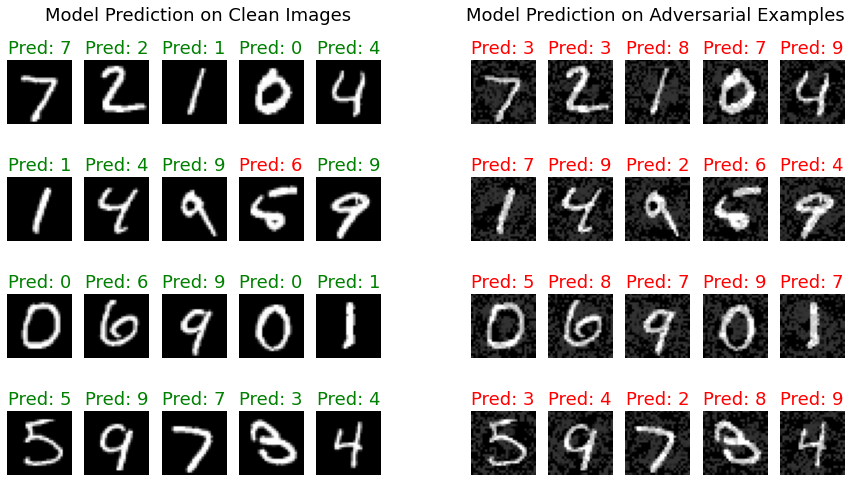

In [9]:
attack_kwargs = {"eps": 0.2, "alpha": 1.25*0.2}
Attack = attacks.RandomPlusFgsm

attacks.attack_visual_demo(fcc_model, Attack, attack_kwargs,
                           x_test[:20], y_test[:20])